**Sentiment Analysis (SA)**

Sentiment analysis aims to express three different polarities about the text under analysis: *positive*, *negative*, and *neutral*.

The algorithms used below are lexicon-based. They are:
- TextBlob
- Vader

See further details below. 

But we can say in advance that a main drawback with a rule-based method for sentiment analysis like these is that it only cares about individual words and completely ignores the context in which it is used. One positive side is they are simple to use, if we compare for example with machine-learning based methods.

Finally, another alternative would be, for example, to use the Python library *spark-nlp*.


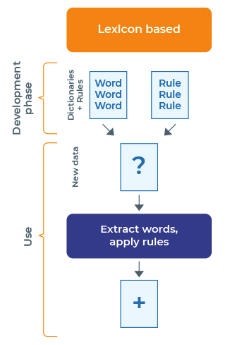

In [1]:
spark

# Initial settings

In [2]:
%%bash
# pip3 install pandas numpy matplot seaborn
# pip3 install -U textblob
# python3 -m textblob.download_corpora lite
# pip3 install vaderSentiment

In [3]:
import os, sys

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# some Spark related imports we will use hereafter

from pyspark.sql import SparkSession 
import pyspark.sql.functions as F 
from pyspark.sql.types import *

In [5]:
# Create Spark session if we want to

spark = SparkSession.builder.appName("ResettingSentimentAnalysis").getOrCreate()

23/07/23 20:47:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Useful functions, namely visualization functions

In [6]:
def plotLine(df, xcol, ycol):
    return sns.lineplot(data=df, x=xcol, y=ycol)

def plotBar(df, xcol, ycol, huecol=None):
    return sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

def plotScatter(df, xcol, ycol, huecol=None):
    return sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

def plotScatterMatrix(df, huecol=None): 
    return sns.pairplot(data=df, hue=huecol)

# Data ingestion

In [7]:
%%bash
ls -la

total 5696
drwxr-xr-x  14 adriano  staff      448 Jul 23 20:46 .
drwxr-xr-x   7 adriano  staff      224 Jul 14 12:13 ..
-rw-r--r--@  1 adriano  staff     6148 Jun 14 23:01 .DS_Store
drwxr-xr-x   9 adriano  staff      288 Jul 23 20:19 .ipynb_checkpoints
drwxr-xr-x@ 16 adriano  staff      512 Jun 12 23:17 data
-rw-r--r--@  1 adriano  staff  2037893 Jul 20 11:26 kaggle_data.zip
drwxr-xr-x  18 adriano  staff      576 Jul 23 20:46 reviews
drwxr-xr-x  18 adriano  staff      576 Jul 23 18:02 reviews-lexicon
-rw-r--r--   1 adriano  staff   114019 Jun 14 22:32 sa-ML.ipynb
-rw-r--r--@  1 adriano  staff   211444 Jul 23 20:46 sa-data-preparation.ipynb
-rw-r--r--@  1 adriano  staff    80636 Jul 23 20:28 sa-lexicon.ipynb
-rw-r--r--   1 adriano  staff     2397 Jun 14 22:32 sa-sparknlp.py
-rw-r--r--   1 adriano  staff     2847 Jun 14 22:58 sa-vader.py
-rw-r--r--   1 adriano  staff   446954 Jul 23 20:33 sa-wordcount.ipynb


In [8]:
# Read the data

df = spark.read.parquet("reviews")


In [9]:
# Check what has been read

df.printSchema()
reviews_count = df.count()
df.show(1, vertical=True, truncate=False)
reviews_count

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Review text: string (nullable = true)
 |-- Collection-date: date (nullable = true)
 |-- Review-date: date (nullable = true)
 |-- Review-sentences-text: string (nullable = true)
 |-- Review-nouns-text: string (nullable = true)
 |-- Review-text-count: integer (nullable = true)
 |-- Review-sentences-text-count: integer (nullable = true)
 |-- Review-nouns-text-count: integer (nullable = true)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 ID                          | 1683301001-136                                                                                                                                

201

# First check
Duplicates, overall nulls

In [10]:
# Check duplicates

[reviews_count, df.dropDuplicates().count()]

[201, 201]

In [11]:
# Check counting with/without nulls

[reviews_count, df.dropna().count()]

[201, 201]

# TextBlob based

It is a simple Python library that offers API access to different NLP tasks such as sentiment analysis, spelling correction, etc.

There are two outcomes: 
- *Polarity* is a float value within the range -1 to 1 where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment; 
- *Subjectivity* is a float value within the range 0 to 1, where 0.0 is very objective and 1.0 is very subjective. A subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations whereas objective sentences are factual.

In [12]:
# Auxiliar UDF functions for text classification using TextBlob

#@F.udf(returnType=FloatType()) 
#def TextBlobPolarity(text):
#    return TextBlob(text).sentiment.polarity

#@F.udf(returnType=FloatType()) 
#def TextBlobSubjectivity(text):
#    return TextBlob(text).sentiment.subjectivity

@F.udf(returnType=MapType(StringType(), FloatType())) 
def TextBlobSentiment(text):
    sentiment = TextBlob(text).sentiment
    return {'polarity': sentiment.polarity, 'subjectivity': sentiment.subjectivity}
    
@F.udf(returnType=StringType()) 
def TextBlobSentimentAnalysis(col):
    if col['polarity'] > 0:
        sentiment = 'Positive'
    elif col['polarity'] < 0:
        sentiment = 'Negative' 
    else:
        sentiment = 'Neutral'
    return sentiment

In [13]:
df = ( df
        .withColumn('TextBlob-sentiment-score', TextBlobSentiment('Review-sentences-text'))
        .withColumn('TextBlob-sentiment', TextBlobSentimentAnalysis('TextBlob-sentiment-score'))
     )

In [14]:
df.printSchema()
df.show(1, vertical=True, truncate=False)

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Review text: string (nullable = true)
 |-- Collection-date: date (nullable = true)
 |-- Review-date: date (nullable = true)
 |-- Review-sentences-text: string (nullable = true)
 |-- Review-nouns-text: string (nullable = true)
 |-- Review-text-count: integer (nullable = true)
 |-- Review-sentences-text-count: integer (nullable = true)
 |-- Review-nouns-text-count: integer (nullable = true)
 |-- TextBlob-sentiment-score: map (nullable = true)
 |    |-- key: string
 |    |-- value: float (valueContainsNull = true)
 |-- TextBlob-sentiment: string (nullable = true)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
df.groupBy('TextBlob-sentiment').count().show()

+------------------+-----+
|TextBlob-sentiment|count|
+------------------+-----+
|          Positive|  193|
|          Negative|    8|
+------------------+-----+



# Vader based
Valence aware dictionary for sentiment reasoning (Vader) is also popular rule-based sentiment analyzer. 

The algorithm uses a list of lexical features (e.g. word) which are labeled as positive or negative, according to their semantic orientation to calculate the text sentiment. The outcome is the probability of a given input sentence to be positive, negative, and neutral.

It is claimed that Vader is optimized specifically for social media data.

In [16]:
# Auxiliar UDF functions for text classification using Vader

@F.udf(returnType=MapType(StringType(), FloatType())) 
def VaderSentiment(text):
    return SentimentIntensityAnalyzer().polarity_scores(text)

@F.udf(returnType=StringType()) 
def VaderSentimentAnalysis(col):
    if col['compound'] >= 0.05:
        sentiment = 'Positive'
    elif col['compound'] <= -0.05:
        sentiment = 'Negative' 
    else:
        sentiment = 'Neutral'
    return sentiment

In [17]:
df = ( df
        .withColumn('Vader-sentiment-score', VaderSentiment('Review-sentences-text'))
        .withColumn('Vader-sentiment', VaderSentimentAnalysis('Vader-sentiment-score'))
     )

In [18]:
df.printSchema()
df.show(1, vertical=True, truncate=False)

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Review text: string (nullable = true)
 |-- Collection-date: date (nullable = true)
 |-- Review-date: date (nullable = true)
 |-- Review-sentences-text: string (nullable = true)
 |-- Review-nouns-text: string (nullable = true)
 |-- Review-text-count: integer (nullable = true)
 |-- Review-sentences-text-count: integer (nullable = true)
 |-- Review-nouns-text-count: integer (nullable = true)
 |-- TextBlob-sentiment-score: map (nullable = true)
 |    |-- key: string
 |    |-- value: float (valueContainsNull = true)
 |-- TextBlob-sentiment: string (nullable = true)
 |-- Vader-sentiment-score: map (nullable = true)
 |    |-- key: string
 |    |-- value: float (valueContainsNull = true)
 |-- Vader-sentiment: string (nullable = true)

-RECORD 0-------------------------------------------------------

In [19]:
df.groupBy('Vader-sentiment').count().show()

+---------------+-----+
|Vader-sentiment|count|
+---------------+-----+
|       Positive|  193|
|       Negative|    8|
+---------------+-----+



# Save the analysed reviews

In [20]:
diff_classification = df.filter(df['TextBlob-sentiment']!=df['vader-sentiment'])
diff_classification.show(vertical=True)
diff_classification.count()


-RECORD 0-------------------------------------------
 ID                          | 1683301384-167       
 Source                      | https://www.tripa... 
 Entity                      | Stone Beach by At... 
 Location                    | Qeparo, Albania      
 Country                     | Albania              
 Review text                 | Horrible, they di... 
 Collection-date             | 2023-05-05           
 Review-date                 | 2021-11-01           
 Review-sentences-text       |  Horrible they di... 
 Review-nouns-text           | horrible didn ’ t... 
 Review-text-count           | 121                  
 Review-sentences-text-count | 131                  
 Review-nouns-text-count     | 23                   
 TextBlob-sentiment-score    | {subjectivity -> ... 
 TextBlob-sentiment          | Negative             
 Vader-sentiment-score       | {neg -> 0.054, po... 
 Vader-sentiment             | Positive             
-RECORD 1-------------------------------------

2

In [21]:
df.columns

['ID',
 'Source',
 'Entity',
 'Location',
 'Country',
 'Review text',
 'Collection-date',
 'Review-date',
 'Review-sentences-text',
 'Review-nouns-text',
 'Review-text-count',
 'Review-sentences-text-count',
 'Review-nouns-text-count',
 'TextBlob-sentiment-score',
 'TextBlob-sentiment',
 'Vader-sentiment-score',
 'Vader-sentiment']

In [22]:
# Save data as a parquet file

df.write.mode("overwrite").parquet("reviews-lexicon")

23/07/23 20:50:53 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /private/var/folders/wl/4zhklts97ms69hcxbggp8fj00000gn/T/blockmgr-fdc9b4a0-5ca1-4bf9-9d7e-1fe5f04efa13. Falling back to Java IO way
java.io.IOException: Failed to delete: /private/var/folders/wl/4zhklts97ms69hcxbggp8fj00000gn/T/blockmgr-fdc9b4a0-5ca1-4bf9-9d7e-1fe5f04efa13
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:177)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:113)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1231)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.Indexe